In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

%run functions.ipynb

In [2]:
orig_data = pd.read_csv('../Data/BankChurners.csv')
orig_data.drop(columns=orig_data.columns[-2:], inplace=True)
X_pre = orig_data.iloc[:,2:-1]
y = np.where(orig_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)
orig_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
X_pre.dtypes

Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
dtype: object

In [4]:
X = pd.get_dummies(X_pre, drop_first=True)
X.dtypes

Customer_Age                        int64
Dependent_count                     int64
Months_on_book                      int64
Total_Relationship_Count            int64
Months_Inactive_12_mon              int64
Contacts_Count_12_mon               int64
Credit_Limit                      float64
Total_Revolving_Bal                 int64
Avg_Open_To_Buy                   float64
Total_Amt_Chng_Q4_Q1              float64
Total_Trans_Amt                     int64
Total_Trans_Ct                      int64
Total_Ct_Chng_Q4_Q1               float64
Gender_M                             bool
Education_Level_Doctorate            bool
Education_Level_Graduate             bool
Education_Level_High School          bool
Education_Level_Post-Graduate        bool
Education_Level_Uneducated           bool
Education_Level_Unknown              bool
Marital_Status_Married               bool
Marital_Status_Single                bool
Marital_Status_Unknown               bool
Income_Category_$40K - $60K       

In [5]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
# define pipeline
over = SMOTE(random_state=0)
under = RandomUnderSampler(random_state=0)
decision_tree = DecisionTreeClassifier(random_state=0)
steps = [('over', over), 
         ('under', under),
         ('classifier', decision_tree)]
model = Pipeline(steps=steps)

In [7]:
#goal is to minimize false negatives (do not want to miss a customer that will churn)
#use recall as primary metric to minimize false negatives
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
cv_scores

array([0.78632479, 0.85470085, 0.83829787, 0.82051282, 0.82478632])

In [8]:
# Make predictions and compute probabilities
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

In [9]:
# Print classification report
print('Baseline model test results')
print(classification_report(y_test, y_pred, target_names=['Existing Customer', 'Attrited Customer']))

Baseline model test results
                   precision    recall  f1-score   support

Existing Customer       0.98      0.95      0.96      2583
Attrited Customer       0.75      0.87      0.81       456

         accuracy                           0.94      3039
        macro avg       0.86      0.91      0.88      3039
     weighted avg       0.94      0.94      0.94      3039



In [10]:
#confusion matrix
cm = confusion_matrix_class(confusion_matrix(y_test, y_pred), inverse=True)
cm.cm

array([[ 395,   61],
       [ 129, 2454]], dtype=int64)

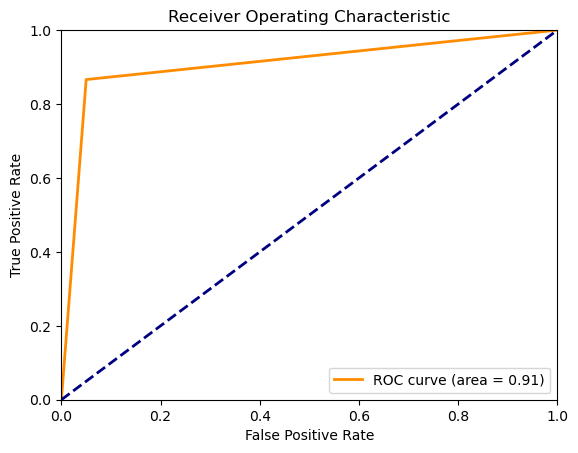

In [11]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

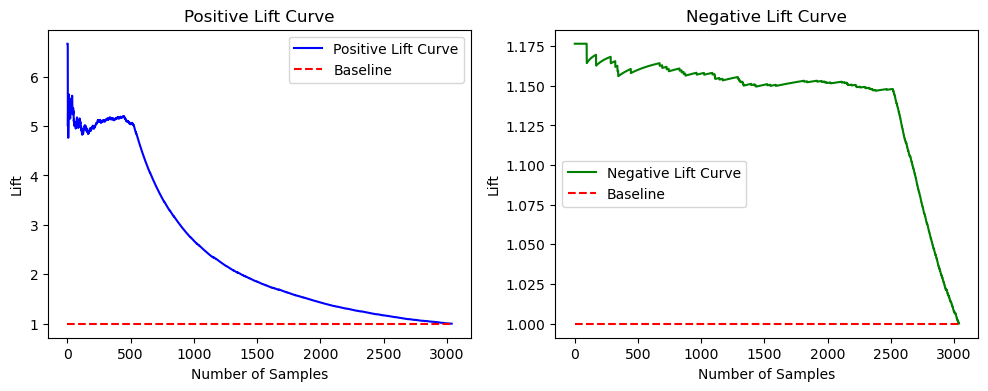

In [12]:
# Plot the lift curves
plot_lift_curves(y_test, y_pred_prob)

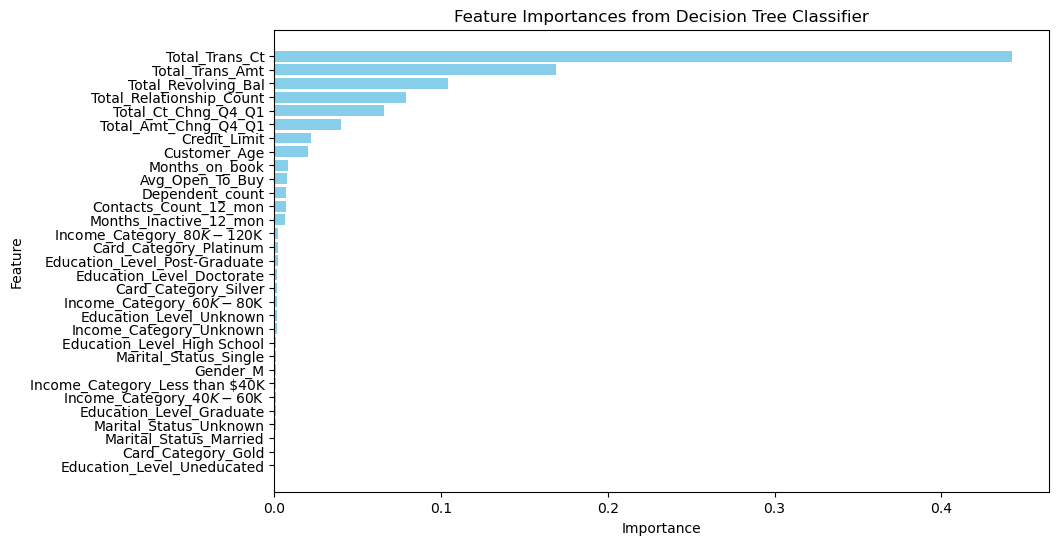

In [13]:
# Get feature importances
classifier = model.named_steps['classifier']
feature_importances = classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [14]:
feature_importances_df

,feature,importance
11,Total_Trans_Ct,0.442511
10,Total_Trans_Amt,0.168790
7,Total_Revolving_Bal,0.103958
3,Total_Relationship_Count,0.078859
12,Total_Ct_Chng_Q4_Q1,0.065552
9,Total_Amt_Chng_Q4_Q1,0.040034
6,Credit_Limit,0.022265
0,Customer_Age,0.020153
2,Months_on_book,0.008252
8,Avg_Open_To_Buy,0.007345
